In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math

trunc_normal= tf.truncated_normal_initializer(stddev=1)
normal = tf.random_normal_initializer(stddev=1)

from NN_architectures import *

/Users/Dave/anaconda3/envs/deepnet/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# some constants

LEARNING_RATE = 0.009
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 1000
SAVE_SAMPLE_PERIOD = 100
task = 'TRAIN'
#task = 'TEST'
PATH='resCNN_test'

In [3]:
global sizes
sizes = {
        
        'conv_layer_0':[(2, 4, 2, False, 0.6, lrelu, normal)],
        'convblock_layer_0': [(8, 4, 1, True, 0.6, lrelu, normal),
                             (16, 4, 1, False, 0.6, lrelu, normal)],
        'convblock_shortcut_layer_0':[(16, 1, 1, False, 1, normal)],
        
        'maxpool_layer_0':[(4, 2, 1)],
        'conv_layer_1':[(16, 8, 2, False, 0.6, lrelu, normal)],
        'convblock_layer_1': [(16, 8, 1, True, 0.6, lrelu, normal),
                             (64, 8, 1, False, 0.6, lrelu, normal)],
        'convblock_shortcut_layer_1':[(64, 8, 1, False, 1, normal)],
        
        'max_pool_layer_1':[(4, 2, 1)],
        'dense_layers':[(1024, True, 0.8, tf.nn.relu, normal)],
        'n_classes':10
}

In [4]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

    X_train = mnist.train.images
    Y_train = mnist.train.labels
    
    X_train = X_train.reshape(len(X_train),28,28,1)
    Y_train = Y_train.reshape(len(Y_train),10)
    
    n_H = X_train.shape[1]
    n_W = X_train.shape[2]
    n_C = X_train.shape[-1]
    
    X_test = mnist.test.images
    Y_test = mnist.test.labels
    
    X_test = X_test.reshape(len(X_test),28,28,1)
    Y_test =  Y_test.reshape(len(Y_test),10)
    
    tf.reset_default_graph()
    cnn = resCNN(n_H, n_W, n_C, sizes,
              lr=LEARNING_RATE, beta1=BETA1,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample=SAVE_SAMPLE_PERIOD, path=PATH)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            cnn.set_session(sess)
            cnn.fit(X_train, Y_train, X_test, Y_test)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            cnn.set_session(sess)

           
        done = False
        while not done:
            
            i = np.random.choice(len(X_test))
            x = X_test[i].reshape(X_test.shape[1],X_test.shape[2],X_test.shape[3])
            ground_truth=np.where(Y_test[i]>0)[0][0]
            p = cnn.predicted_Y_hat([x]).reshape(sizes['n_classes'])
            prediction = np.where(p==np.max(p))[0][0]
            
            
            plt.clf()
            plt.imshow(x.reshape(
                                X_test.shape[1],
                                X_test.shape[2]),
                                cmap='gray'
                      )
            plt.title('Input image')
            plt.show()
            
            print('True class: '+str(ground_truth)+'\n'+
                  'Predicted class: '+str(prediction)+'\n')
                  
            
            

            ans = input("Predict another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Convolution
Input for convolution shape  (?, 28, 28, 1)
Logits shape (?, 10)
Convolution
Input for convolution shape  (?, 28, 28, 1)
Logits shape (?, 10)

 Training...

 ****** 

Training residual CNN for 1000 epochs with a total of 55000 samples
distributed in 429 batches of size 128

The learning rate set is 0.009

 ****** 

Evaluating performance on train/test sets
At iteration 0, train cost: 0.01672, train accuracy 0.2955
test accuracy 0.125
Evaluating performance on train/test sets
At iteration 100, train cost: 0.01593, train accuracy 0.375
test accuracy 0.3125
Evaluating performance on train/test sets
At iteration 200, train cost: 0.01575, train accuracy 0.3295
test accuracy 0.3125
Evaluating performance on train/test sets
At iteration 300, train cost: 0.01612, train accuracy 0.3977
test a

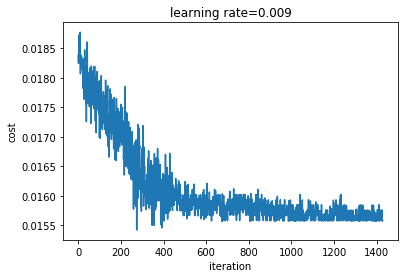

Parameters trained
Model saved in path: resCNN_test/resCNN_test.ckpt


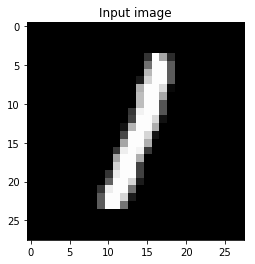

True class: 1
Predicted class: 1

Predict another?


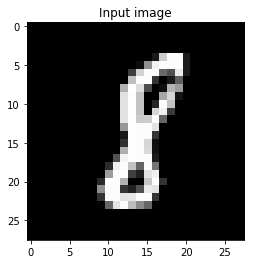

True class: 8
Predicted class: 1

Predict another?


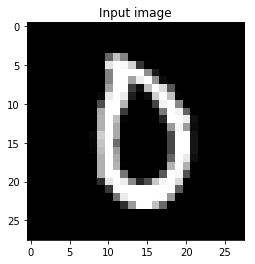

True class: 0
Predicted class: 1

Predict another?


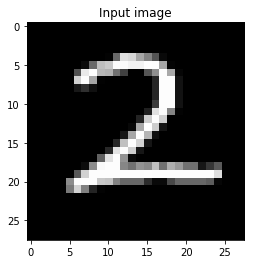

True class: 2
Predicted class: 6

Predict another?


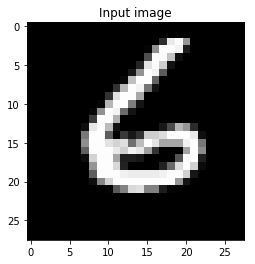

True class: 6
Predicted class: 6

Predict another?n


In [5]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()